In [17]:
import torch
from torchvision import datasets, transforms

# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
# Download and load training data
trainset = datasets.FashionMNIST('FashionMNIST/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('FashionMNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

In [29]:
images, labels = next(iter(testloader))
print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [32]:
from torch import nn, optim
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0],-1)
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

In [34]:
model = Classifier()

images, labels = next(iter(testloader))

print(model)
# Get the class probabalities
ps = torch.exp(model(images))
# Make sure the shape is appropriate, we should get 10 class probabilities for 64 examples
print(ps.shape)

Classifier(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=64, bias=True)
  (fc4): Linear(in_features=64, out_features=10, bias=True)
)
torch.Size([64, 10])


In [55]:
# Now with above probabilities, ps.topk method returns k highest values
# to get most likely class, we use ps.topk(1) since it is nearer to 1?
# This returns a tuple of top-k values and the topk indices
# if the highest value is the fifth element, we'll get back 4 as the index
top_p, top_class = ps.topk(1, dim=1)
print(top_class[:10,:])

tensor([[6],
        [8],
        [6],
        [6],
        [6],
        [8],
        [8],
        [8],
        [8],
        [8]])


In [56]:
print(top_class.shape)
print(labels.view(*top_class.shape).shape)

torch.Size([64, 1])
torch.Size([64, 1])


In [57]:
equals = top_class == labels.view(*top_class.shape)

In [58]:
print(equals)
print(equals.shape)

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False

In [62]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 7.8125%


In [63]:
# Above accuracy is based on with any training
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # reset any previous gradients
        optimizer.zero_grad()
        # forward feed
        log_ps = model(images)
        # loss
        loss = criterion(log_ps, labels)
        # backward propagation
        loss.backward()
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
    else:
        ## Implement the validation pass and print out the validation accuracy
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
                
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training Loss: {:3f}..".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
              "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))
        

Epoch: 1/30.. Training Loss: 0.513422.. Test Loss: 0.464.. Test Accuracy: 0.837
Epoch: 2/30.. Training Loss: 0.390877.. Test Loss: 0.413.. Test Accuracy: 0.848
Epoch: 3/30.. Training Loss: 0.357694.. Test Loss: 0.388.. Test Accuracy: 0.866
Epoch: 4/30.. Training Loss: 0.334220.. Test Loss: 0.400.. Test Accuracy: 0.853
Epoch: 5/30.. Training Loss: 0.319416.. Test Loss: 0.374.. Test Accuracy: 0.863
Epoch: 6/30.. Training Loss: 0.305163.. Test Loss: 0.394.. Test Accuracy: 0.867
Epoch: 7/30.. Training Loss: 0.292181.. Test Loss: 0.379.. Test Accuracy: 0.867
Epoch: 8/30.. Training Loss: 0.285078.. Test Loss: 0.362.. Test Accuracy: 0.872
Epoch: 9/30.. Training Loss: 0.278306.. Test Loss: 0.384.. Test Accuracy: 0.868
Epoch: 10/30.. Training Loss: 0.268553.. Test Loss: 0.360.. Test Accuracy: 0.876
Epoch: 11/30.. Training Loss: 0.261646.. Test Loss: 0.369.. Test Accuracy: 0.879
Epoch: 12/30.. Training Loss: 0.251565.. Test Loss: 0.378.. Test Accuracy: 0.874
Epoch: 13/30.. Training Loss: 0.24769

In [64]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

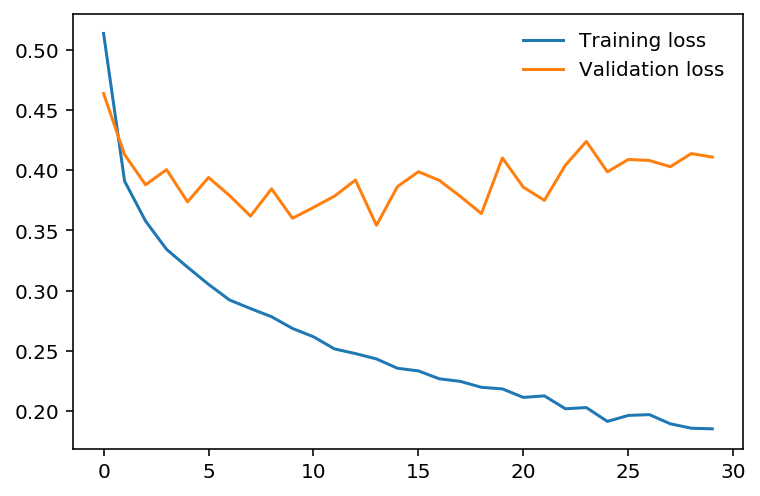

In [65]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

In [67]:
## Implementing Classifer with dropout to solve above issue
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 10)
        
        # Dropout module with 0.2 drop probability
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0],-1)
        
        # Now with dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        
        # output so no dropout here
        x = F.log_softmax(self.fc4(x), dim=1)
        return x

In [73]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        # make sure of no previous gradients
        optimizer.zero_grad()
        # forward feed
        log_ps = model(images)
        # calculate loss
        loss = criterion(log_ps, labels)
        # back prop
        loss.backward()
        # update the weights
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        
        # Turn off gradients
        with torch.no_grad():
            # set model to evaluation mode
            model.eval()
            for images, labels in testloader:
                log_ps = model(images)
                test_loss += criterion(log_ps, labels)
                
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor))
        
        # Resume dropouts during training
        model.train()
        
        train_losses.append(running_loss/len(trainloader))
        test_losses.append(test_loss/len(testloader))
        
        print("Epoch: {}/{}..".format(e+1, epochs),
              "Training Loss: {:.3f}..".format(running_loss/len(trainloader)),
              "Test Loss: {:.3f}..".format(test_loss/len(testloader)),
              "Test Accuracy : {:.3f}".format(accuracy/len(testloader)))
    

Epoch: 1/30.. Training Loss: 0.602.. Test Loss: 0.488.. Test Accuracy : 0.821
Epoch: 2/30.. Training Loss: 0.479.. Test Loss: 0.466.. Test Accuracy : 0.835
Epoch: 3/30.. Training Loss: 0.448.. Test Loss: 0.439.. Test Accuracy : 0.841
Epoch: 4/30.. Training Loss: 0.431.. Test Loss: 0.412.. Test Accuracy : 0.853
Epoch: 5/30.. Training Loss: 0.420.. Test Loss: 0.398.. Test Accuracy : 0.860
Epoch: 6/30.. Training Loss: 0.408.. Test Loss: 0.397.. Test Accuracy : 0.860
Epoch: 7/30.. Training Loss: 0.405.. Test Loss: 0.393.. Test Accuracy : 0.864
Epoch: 8/30.. Training Loss: 0.397.. Test Loss: 0.410.. Test Accuracy : 0.857
Epoch: 9/30.. Training Loss: 0.387.. Test Loss: 0.396.. Test Accuracy : 0.860
Epoch: 10/30.. Training Loss: 0.387.. Test Loss: 0.399.. Test Accuracy : 0.864
Epoch: 11/30.. Training Loss: 0.384.. Test Loss: 0.390.. Test Accuracy : 0.864
Epoch: 12/30.. Training Loss: 0.383.. Test Loss: 0.385.. Test Accuracy : 0.865
Epoch: 13/30.. Training Loss: 0.374.. Test Loss: 0.378.. Test

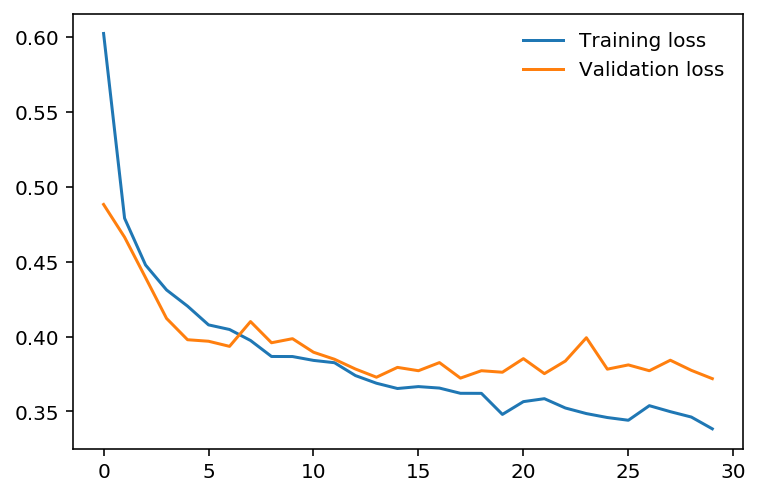

In [74]:
# After dropout verify the loss
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)